Portfolio Optimalization - Asset Management
\ Arno Goedhuys
\ r0636556
\ 29 juni 2017

In [431]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline

Downloading the data from google finance.

In [432]:
#assets = ['CBG', 'GLD', 'XOM', 'KO', 'FOX', 'BIIB','GOOGL']
#assets = ['NOK', "DE", "FIS", "HON", 'FL', 'PEG','GG','ZBH','EXR']
assets = ['AAPL','MSFT','AMZN','YHOO']
amount_of_assets = len(assets)
pf_data = pd.DataFrame()

for asset in assets:
    pf_data[asset] = wb.DataReader(asset, data_source = 'google', start='2009-1-1')['Close']

In [433]:
pf_data.tail()

,AAPL,MSFT,AMZN,YHOO
Date,,,,
2017-06-23,146.28,71.21,1003.74,54.73
2017-06-26,145.82,70.53,993.98,54.31
2017-06-27,143.73,69.21,976.78,53.64
2017-06-28,145.83,69.80,990.33,54.95
2017-06-29,143.68,68.49,975.93,54.30


Normalize data so each asset starts with a value of 100 and plot the evolution of each asset.

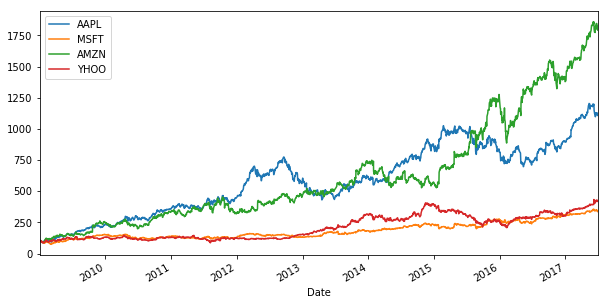

In [434]:
normalized_data = pf_data / pf_data.iloc[0] * 100
(normalized_data).plot(figsize=(10,5))

A function to generate a given amount of random weights while making sure the sum of the weights equals 1.

In [435]:
def gen_random_weights(amount):
    weights = np.random.random(amount)
    weights /= np.sum(weights)
    return weights
print gen_random_weights(amount_of_assets)

[ 0.17317442  0.1882381   0.34626927  0.29231821]


A function to calculate the mean annual return of the portfolio.

In [436]:
def portfolio_return(assets, weights):
    log_returns = np.log(assets / assets.shift(1))
    annual_returns = log_returns.mean() * 252
    total_return = np.sum(annual_returns * weights)
    return total_return

portfolio_return(normalized_data, gen_random_weights(amount_of_assets))

0.23146640321638778

A function to calculate the volatility of a portfolio.

In [437]:
def portfolio_volatility(assets, weights):
    log_returns = np.log(assets / assets.shift(1))
    cov_matrix = log_returns.cov() * 252
    total_volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
    return total_volatility

portfolio_volatility(normalized_data, gen_random_weights(amount_of_assets))

0.23890957374934177

The return in function of the weights this will be of use for the optimization.

In [438]:
def returns(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = log_returns.mean() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -np.sum(annual_returns * variable)

The risk in function of the weights also to be used in the optimization.

In [439]:
def risk(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    cov_matrix = log_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable)))


The sharp ratio in function of the weights.

In [440]:
def sharp(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = log_returns.mean() * 252
    cov_matrix = log_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -(np.sum(annual_returns * variable)) / (np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable)))) 

The contraint for the optimization, that the sum of the weights must be equal to one. 

In [441]:
def constraint12(x):
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return np.sum(variable) - 1

A function to generate the valid interval for each weight.

In [442]:
def gen_bounds(amount):
    bounds = []
    for i in range(amount):
        bounds.append((0,0.5))
    return bounds

Make an initial guess by brute force to make the optimazation better.

In [443]:
def initial_guess(assets, amount_of_samples):
    min_risk = 1
    min_risk_weights = gen_random_weights(amount_of_assets)
    max_sharp = 0
    max_sharp_weights = gen_random_weights(amount_of_assets)
    for x in range(amount_of_samples):
        weights = gen_random_weights(amount_of_assets)
        port_risk = portfolio_volatility(assets, weights)
        port_return = portfolio_return(assets, weights)
        if port_risk < min_risk:
            min_risk = port_risk
            min_risk_weights = weights
        if port_return/port_risk > max_sharp:
            max_sharp = port_return/port_risk
            max_sharp_weights = weights
    return [min_risk_weights, max_sharp_weights]

The optimization for the minimal risk portfolio. The extra constraints that each weight lies between 0 and 0.5 are set by the 
bounds attribute.

In [444]:
minimal_risk_weights = optimize.fmin_slsqp(risk, initial_guess(normalized_data,2500)[0].tolist(),eqcons=[constraint12],
                     bounds=gen_bounds(amount_of_assets))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.205733378767
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 3


The optimization for the maximal sharp portfolio. The extra constraints that each weights lies between 0 and 0.5 are set by the bounds attribute.

In [445]:
maximal_sharp_weights = optimize.fmin_slsqp(sharp, initial_guess(normalized_data,2500)[1].tolist(),eqcons=[constraint12],
                     bounds=gen_bounds(amount_of_assets))
maximal_sharp_weights

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1.25090400119
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


array([ 0.55280209,  0.02688006,  0.41543348,  0.00488438])

A plot of a given amount of portfolios made up from the same given assets. It plots each portfolio as a dot in function of 
the portfolios expected yearly return and volatility. The previously calculated optimal portfolios are also plotted as stars. The functions output are the weights of the assets that the respective portfolios are made of and the weights of the best match from the other portfolios.

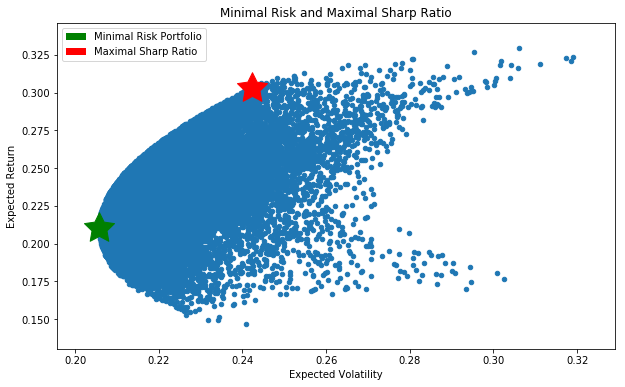

[array([ 0.33768104,  0.41399438,  0.07704182,  0.17128277]),
 array([ 0.58564722,  0.00460173,  0.39696089,  0.01279015]),
 array([ 0.33186527,  0.41693913,  0.079975  ,  0.1712206 ]),
 array([ 0.55280209,  0.02688006,  0.41543348,  0.00488438])]

In [446]:
def example_plot(assets, amount_of_samples):
    returns = []
    risks = []
    min_risk = 1
    min_risk_weights = gen_random_weights(amount_of_assets)
    max_sharp = 0
    max_sharp_weights = gen_random_weights(amount_of_assets)
    for x in range(amount_of_samples):
        weights = gen_random_weights(amount_of_assets)
        port_risk = portfolio_volatility(assets, weights)
        risks.append(port_risk)
        port_return = portfolio_return(assets, weights)
        returns.append(port_return)
        if port_risk < min_risk:
            min_risk = port_risk
            min_risk_weights = weights
        if port_return/port_risk > max_sharp:
            max_sharp = port_return/port_risk
            max_sharp_weights = weights
    returns = np.array(returns)
    risks = np.array(risks)
    portfolios = pd.DataFrame({'Return': returns, 'Volatility': risks})
    portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10,6));
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    
    port_minrisk = portfolio_volatility(assets, minimal_risk_weights)
    port_return = portfolio_return(assets, minimal_risk_weights)
    plt.scatter(port_minrisk,port_return,marker=(5,1,0),color='g',s=1000)
    
    port_maxsharp = portfolio_volatility(assets, maximal_sharp_weights)
    port_return = portfolio_return(assets, maximal_sharp_weights)
    plt.scatter(port_maxsharp,port_return,marker=(5,1,0),color='r',s=1000)
    
    plt.title("Minimal Risk and Maximal Sharp Ratio")
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='g')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='r')

    plt.legend((p1, p2), ('Minimal Risk Portfolio', 'Maximal Sharp Ratio'), loc='best')
    plt.show()
    return [min_risk_weights, max_sharp_weights, minimal_risk_weights, maximal_sharp_weights]
example_plot(normalized_data, 25000)

The first array is the best minimal risk portfolio out of the 25000 random portfolios.
The third array represents the portfolio that was calculated in the minimal risk optimalization.
The second array is the best maximal sharp ratio portfolio out of the 25000 random portfolios.
The fourth array represents the portfolio that was calculated in the maximal sharp ratio optimalization.